In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import joblib

from pathlib import Path
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

EDA_SAMPLE_N = 200_000

In [43]:
#Loading Dataset

df = pd.read_csv(r"C:\Users\cflin\OneDrive\Desktop\ANA 680\Week 4\Final Project\gaming_mental_health_10M_40features.csv")

print(df.shape)
display(df.head())
df.info()


(1000000, 39)


,age,gender,income,daily_gaming_hours,weekly_sessions,years_gaming,sleep_hours,caffeine_intake,exercise_hours,stress_level,...,parental_supervision,loneliness_score,aggression_score,happiness_score,bmi,screen_time_total,eye_strain_score,back_pain_score,competitive_rank,internet_quality
0,51,Female,8615,3.68,22,17,5.26,1.00,0.18,3,...,0,2.87,3.19,5.20,19.69,4.71,5.71,4.81,80,10
1,41,Female,39453,5.70,34,16,9.20,0.70,1.44,8,...,7,4.17,7.73,5.40,26.37,6.62,6.77,3.99,57,2
2,27,Male,40466,1.58,8,22,7.39,2.24,3.15,3,...,9,9.38,2.85,5.17,25.15,9.30,2.16,4.75,59,10
3,55,Male,51076,6.11,39,24,7.99,1.65,2.80,1,...,5,8.24,7.19,8.62,26.42,13.81,4.72,5.37,89,1
4,20,Male,86116,3.65,17,0,7.12,1.02,1.01,2,...,9,6.65,2.53,9.71,25.75,10.74,3.90,6.44,15,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   age                         1000000 non-null  int64  
 1   gender                      1000000 non-null  object 
 2   income                      1000000 non-null  int64  
 3   daily_gaming_hours          1000000 non-null  float64
 4   weekly_sessions             1000000 non-null  int64  
 5   years_gaming                1000000 non-null  int64  
 6   sleep_hours                 1000000 non-null  float64
 7   caffeine_intake             1000000 non-null  float64
 8   exercise_hours              1000000 non-null  float64
 9   stress_level                1000000 non-null  int64  
 10  anxiety_score               1000000 non-null  float64
 11  depression_score            1000000 non-null  float64
 12  social_interaction_score    1000000 non-null  float64
 13

In [45]:
# Loading Dataset because its so large I am setting some parameters to save on computing
DATA_PATH = r"C:\Users\cflin\OneDrive\Desktop\ANA 680\Week 4\Final Project\gaming_mental_health_10M_40features.csv"

USE_SAMPLE = True
NROWS = EDA_SAMPLE_N

if USE_SAMPLE:
    df = pd.read_csv(DATA_PATH, nrows=NROWS, low_memory=False)
else:
    df = pd.read_csv(DATA_PATH, low_memory=False)

print("df shape:", df.shape)
display(df.head())
df.info()

mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Approx. memory usage (loaded df): {mem_mb:,.2f} MB")

df shape: (200000, 39)


,age,gender,income,daily_gaming_hours,weekly_sessions,years_gaming,sleep_hours,caffeine_intake,exercise_hours,stress_level,anxiety_score,depression_score,social_interaction_score,relationship_satisfaction,academic_performance,work_productivity,addiction_level,multiplayer_ratio,toxic_exposure,violent_games_ratio,mobile_gaming_ratio,night_gaming_ratio,weekend_gaming_hours,friends_gaming_count,online_friends,streaming_hours,esports_interest,headset_usage,microtransactions_spending,parental_supervision,loneliness_score,aggression_score,happiness_score,bmi,screen_time_total,eye_strain_score,back_pain_score,competitive_rank,internet_quality
0,51,Female,8615,3.68,22,17,5.26,1.00,0.18,3,4.06,5.02,7.85,9.55,68.80,77.12,2.02,0.39,0.05,0.51,0.23,0.32,1.50,20,186,2.82,1,1,1746.97,0,2.87,3.19,5.20,19.69,4.71,5.71,4.81,80,10
1,41,Female,39453,5.70,34,16,9.20,0.70,1.44,8,6.76,7.63,7.06,6.96,38.11,44.94,5.85,0.23,0.37,0.43,0.24,0.32,17.93,37,21,1.34,8,1,342.04,7,4.17,7.73,5.40,26.37,6.62,6.77,3.99,57,2
2,27,Male,40466,1.58,8,22,7.39,2.24,3.15,3,9.57,4.02,1.12,2.61,97.44,54.77,0.08,0.06,0.15,0.48,0.27,0.42,2.99,45,146,3.56,8,1,57.95,9,9.38,2.85,5.17,25.15,9.30,2.16,4.75,59,10
3,55,Male,51076,6.11,39,24,7.99,1.65,2.80,1,4.97,1.40,6.59,6.00,67.65,88.56,2.77,0.53,0.36,0.64,0.57,0.82,1.99,11,133,1.80,6,1,617.32,5,8.24,7.19,8.62,26.42,13.81,4.72,5.37,89,1
4,20,Male,86116,3.65,17,0,7.12,1.02,1.01,2,8.73,4.83,6.03,3.54,62.34,68.82,3.37,0.78,0.25,0.29,0.47,0.83,9.23,24,399,1.30,4,0,1398.39,9,6.65,2.53,9.71,25.75,10.74,3.90,6.44,15,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         200000 non-null  int64  
 1   gender                      200000 non-null  object 
 2   income                      200000 non-null  int64  
 3   daily_gaming_hours          200000 non-null  float64
 4   weekly_sessions             200000 non-null  int64  
 5   years_gaming                200000 non-null  int64  
 6   sleep_hours                 200000 non-null  float64
 7   caffeine_intake             200000 non-null  float64
 8   exercise_hours              200000 non-null  float64
 9   stress_level                200000 non-null  int64  
 10  anxiety_score               200000 non-null  float64
 11  depression_score            200000 non-null  float64
 12  social_interaction_score    200000 non-null  float64
 13  relationship_s

In [46]:
# Examining my data 

df_eda = df
if len(df) > 200_000:
    df_eda = df.sample(200_000, random_state=42)

print("df shape:", df.shape)
print("df_eda shape:", df_eda.shape)

display(df_eda.dtypes.to_frame("dtype").T)

missing = df_eda.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
display(missing.head(15).to_frame("missing_count"))

display(df_eda.describe())

df shape: (200000, 39)
df_eda shape: (200000, 39)


,age,gender,income,daily_gaming_hours,weekly_sessions,years_gaming,sleep_hours,caffeine_intake,exercise_hours,stress_level,anxiety_score,depression_score,social_interaction_score,relationship_satisfaction,academic_performance,work_productivity,addiction_level,multiplayer_ratio,toxic_exposure,violent_games_ratio,mobile_gaming_ratio,night_gaming_ratio,weekend_gaming_hours,friends_gaming_count,online_friends,streaming_hours,esports_interest,headset_usage,microtransactions_spending,parental_supervision,loneliness_score,aggression_score,happiness_score,bmi,screen_time_total,eye_strain_score,back_pain_score,competitive_rank,internet_quality
dtype,int64,object,int64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64


,missing_count


,age,income,daily_gaming_hours,weekly_sessions,years_gaming,sleep_hours,caffeine_intake,exercise_hours,stress_level,anxiety_score,depression_score,social_interaction_score,relationship_satisfaction,academic_performance,work_productivity,addiction_level,multiplayer_ratio,toxic_exposure,violent_games_ratio,mobile_gaming_ratio,night_gaming_ratio,weekend_gaming_hours,friends_gaming_count,online_friends,streaming_hours,esports_interest,headset_usage,microtransactions_spending,parental_supervision,loneliness_score,aggression_score,happiness_score,bmi,screen_time_total,eye_strain_score,back_pain_score,competitive_rank,internet_quality
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,35.984350,77449.687405,4.006938,19.986510,11.990070,6.998803,1.996431,1.999015,5.493630,5.001494,5.007091,5.980940,5.986848,69.904891,69.864565,2.832105,0.500421,0.285216,0.400334,0.500242,0.500391,6.008308,24.557130,249.665620,2.003809,5.005690,0.500545,500.274482,5.002705,4.996585,5.003915,5.990886,23.998414,8.012604,5.002930,4.015581,49.499815,5.501265
std,13.563101,41831.877722,2.837001,11.267647,7.209524,1.502767,1.993503,2.005823,2.875314,1.978857,2.399021,1.955392,1.955477,14.715177,14.698766,2.113377,0.223535,0.159460,0.200086,0.223892,0.223416,4.251915,14.420826,144.383243,1.412860,3.157153,0.500001,499.877482,3.160109,1.976166,1.983604,1.963129,3.998513,4.001561,1.979381,1.950018,28.858049,2.869866
min,13.000000,5000.000000,0.000000,1.000000,0.000000,0.270000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.630000,2.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.450000,0.210000,0.000000,0.000000,0.000000,1.000000
25%,24.000000,41171.000000,1.920000,10.000000,6.000000,5.990000,0.570000,0.580000,3.000000,3.660000,3.320000,4.650000,4.650000,59.910000,59.900000,1.260000,0.330000,0.160000,0.240000,0.330000,0.330000,2.890000,12.000000,125.000000,0.960000,2.000000,0.000000,144.140000,2.000000,3.650000,3.650000,4.650000,21.300000,5.080000,3.650000,2.660000,24.000000,3.000000
50%,36.000000,77285.000000,3.360000,20.000000,12.000000,7.000000,1.380000,1.380000,5.000000,5.010000,5.010000,6.000000,6.000000,70.000000,70.000000,2.470000,0.500000,0.260000,0.390000,0.500000,0.500000,5.050000,25.000000,250.000000,1.680000,5.000000,1.000000,346.830000,5.000000,5.000000,5.000000,6.010000,24.000000,7.370000,5.000000,4.000000,50.000000,6.000000
75%,48.000000,113722.000000,5.400000,30.000000,18.000000,8.010000,2.770000,2.770000,8.000000,6.350000,6.690000,7.340000,7.350000,80.140000,80.160000,4.000000,0.670000,0.390000,0.540000,0.670000,0.670000,8.090000,37.000000,375.000000,2.700000,8.000000,1.000000,694.150000,8.000000,6.340000,6.360000,7.360000,26.680000,10.240000,6.350000,5.340000,74.000000,8.000000
max,59.000000,149999.000000,26.810000,39.000000,24.000000,13.990000,24.100000,26.480000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,100.000000,10.000000,1.000000,0.930000,0.990000,1.000000,1.000000,43.150000,49.000000,499.000000,15.100000,10.000000,1.000000,5588.200000,10.000000,10.000000,10.000000,10.000000,43.600000,42.680000,10.000000,10.000000,99.000000,10.000000


In [47]:
# Cleaning my Data 

df.columns = df.columns.str.strip()

df = df.drop_duplicates()

obj_cols = df.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df[c] = df[c].astype("string").str.strip()

print("df shape after basic cleaning:", df.shape)

df shape after basic cleaning: (200000, 39)


In [49]:
#Creating my target feature

TARGET_COL = "addiction_level"

threshold = df[TARGET_COL].quantile(0.80)
print("80th percentile threshold:", threshold)

df["high_addiction"] = (df[TARGET_COL] >= threshold).astype(int)

display(df["high_addiction"].value_counts())
display(df["high_addiction"].value_counts(normalize=True).rename("proportion"))

80th percentile threshold: 4.44


high_addiction
0    159822
1     40178
Name: count, dtype: int64

high_addiction
0    0.79911
1    0.20089
Name: proportion, dtype: float64

In [70]:
# Rank numeric features by absolute mean difference between classes to figure out what to use

exclude_cols = ["high_addiction", "addiction_level"]
numeric_cols = df_eda.drop(columns=exclude_cols).select_dtypes(include=["number"]).columns

means_0 = df_eda[df_eda["high_addiction"] == 0][numeric_cols].mean()
means_1 = df_eda[df_eda["high_addiction"] == 1][numeric_cols].mean()

diff = (means_1 - means_0).sort_values(key=lambda s: s.abs(), ascending=False)

top20 = pd.DataFrame({
    "mean_0": means_0[diff.index],
    "mean_1": means_1[diff.index],
    "diff_(1-0)": diff
}).head(20)

display(top20)

,mean_0,mean_1,diff_(1-0)
income,77470.944057,77365.131664,-105.812392
daily_gaming_hours,2.967851,8.140271,5.172420
screen_time_total,6.976434,12.134328,5.157894
microtransactions_spending,499.312066,504.102829,4.790763
online_friends,249.451846,250.515979,1.064132
competitive_rank,49.532048,49.371596,-0.160452
age,36.002328,35.912838,-0.089490
weekly_sessions,19.973483,20.038329,0.064846
academic_performance,69.895280,69.943122,0.047842
years_gaming,11.982293,12.021007,0.038714


In [75]:
# Defining Features

DEPLOY_FEATURES = [
    "age",
    "gender",
    "daily_gaming_hours",
    "weekly_sessions",
    "years_gaming",
    "competitive_rank",
    "online_friends",
    "microtransactions_spending",
    "screen_time_total",
    "sleep_hours",
    "stress_level",
    "depression_score"
]

X = df[DEPLOY_FEATURES].copy()
y = df["high_addiction"].copy()

print("X shape:", X.shape)
print("Features:", DEPLOY_FEATURES)

X shape: (200000, 12)
Features: ['age', 'gender', 'daily_gaming_hours', 'weekly_sessions', 'years_gaming', 'competitive_rank', 'online_friends', 'microtransactions_spending', 'screen_time_total', 'sleep_hours', 'stress_level', 'depression_score']


In [77]:
# EDA 

df_eda = df.sample(200_000, random_state=42) if len(df) > 200_000 else df

needed_cols = ["high_addiction"] + DEPLOY_FEATURES
missing_cols = [c for c in needed_cols if c not in df_eda.columns]
if missing_cols:
    raise ValueError(f"Missing columns needed for EDA: {missing_cols}")

df_sub = df_eda[needed_cols].copy()
print("df_sub shape:", df_sub.shape)

display(df_sub["high_addiction"].value_counts())
display(df_sub["high_addiction"].value_counts(normalize=True).rename("proportion"))

display(df_sub.dtypes.to_frame("dtype"))

missing = df_sub.isna().sum().sort_values(ascending=False)
display(missing.to_frame("missing_count"))

display(df_sub.describe(include="all"))

df_sub shape: (200000, 13)


high_addiction
0    159822
1     40178
Name: count, dtype: int64

high_addiction
0    0.79911
1    0.20089
Name: proportion, dtype: float64

,dtype
high_addiction,int64
age,int64
gender,string[python]
daily_gaming_hours,float64
weekly_sessions,int64
years_gaming,int64
competitive_rank,int64
online_friends,int64
microtransactions_spending,float64
screen_time_total,float64


,missing_count
high_addiction,0
age,0
gender,0
daily_gaming_hours,0
weekly_sessions,0
years_gaming,0
competitive_rank,0
online_friends,0
microtransactions_spending,0
screen_time_total,0


,high_addiction,age,gender,daily_gaming_hours,weekly_sessions,years_gaming,competitive_rank,online_friends,microtransactions_spending,screen_time_total,sleep_hours,stress_level,depression_score
count,200000.000000,200000.000000,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,96135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.200890,35.984350,NaN,4.006938,19.986510,11.990070,49.499815,249.665620,500.274482,8.012604,6.998803,5.493630,5.007091
std,0.400667,13.563101,NaN,2.837001,11.267647,7.209524,28.858049,144.383243,499.877482,4.001561,1.502767,2.875314,2.399021
min,0.000000,13.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.210000,0.270000,1.000000,0.000000
25%,0.000000,24.000000,NaN,1.920000,10.000000,6.000000,24.000000,125.000000,144.140000,5.080000,5.990000,3.000000,3.320000
50%,0.000000,36.000000,NaN,3.360000,20.000000,12.000000,50.000000,250.000000,346.830000,7.370000,7.000000,5.000000,5.010000
75%,0.000000,48.000000,NaN,5.400000,30.000000,18.000000,74.000000,375.000000,694.150000,10.240000,8.010000,8.000000,6.690000


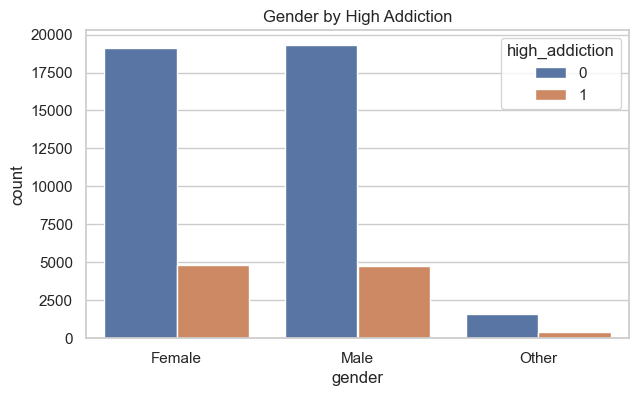

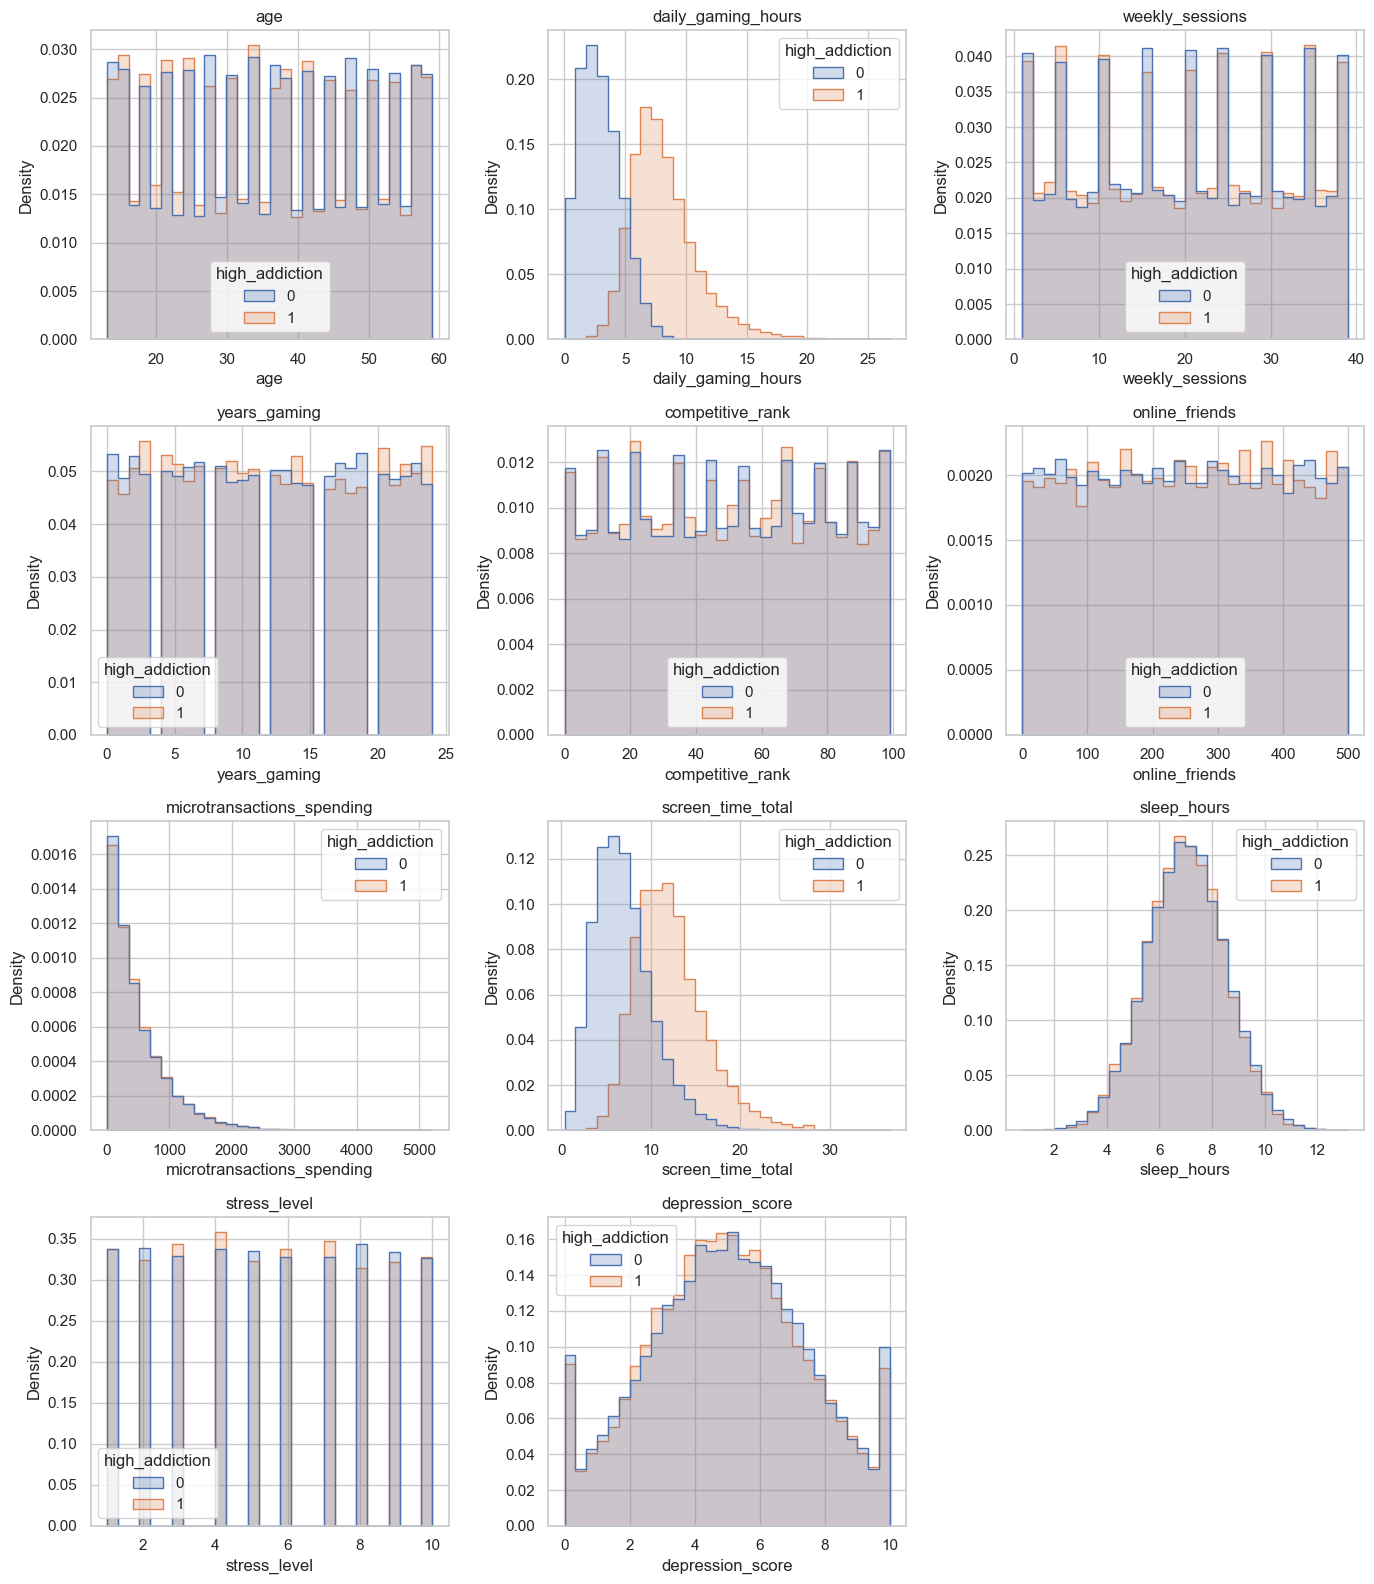

In [78]:
# EDA Features Distrbution 

df_plot = df_sub.sample(50_000, random_state=42) if len(df_sub) > 50_000 else df_sub

plt.figure(figsize=(7,4))
sns.countplot(data=df_plot, x="gender", hue="high_addiction")
plt.title("Gender by High Addiction")
plt.xlabel("gender")
plt.ylabel("count")
plt.legend(title="high_addiction")
plt.show()

num_feats = [c for c in DEPLOY_FEATURES if c != "gender"]

cols = 3
rows = int(np.ceil(len(num_feats) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = axes.flatten()

for i, col in enumerate(num_feats):
    sns.histplot(
        data=df_plot, x=col, hue="high_addiction",
        bins=30, element="step",
        stat="density", common_norm=False,
        ax=axes[i]
    )
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [81]:
#Preprocessing my data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

display(X_train.dtypes)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool", "string"]).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

age                                    int64
gender                        string[python]
daily_gaming_hours                   float64
weekly_sessions                        int64
years_gaming                           int64
competitive_rank                       int64
online_friends                         int64
microtransactions_spending           float64
screen_time_total                    float64
sleep_hours                          float64
stress_level                           int64
depression_score                     float64
dtype: object

Numeric cols: ['age', 'daily_gaming_hours', 'weekly_sessions', 'years_gaming', 'competitive_rank', 'online_friends', 'microtransactions_spending', 'screen_time_total', 'sleep_hours', 'stress_level', 'depression_score']
Categorical cols: ['gender']


In [80]:
# Train/Validation/Test 70 15 15 Split

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

print("\nTrain class balance:")
print(y_train.value_counts(normalize=True))

Train: (140000, 12) (140000,)
Val:   (30000, 12) (30000,)
Test:  (30000, 12) (30000,)

Train class balance:
high_addiction
0    0.799107
1    0.200893
Name: proportion, dtype: float64


In [82]:
#Building my Logistic Regression Model

deploy_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

deploy_clf.fit(X_train, y_train)

val_proba = deploy_clf.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("Validation ROC-AUC:", roc_auc_score(y_val, val_proba))
print("Validation Avg Precision:", average_precision_score(y_val, val_proba))
print("\nConfusion Matrix (val):\n", confusion_matrix(y_val, val_pred))
print("\nClassification Report (val):\n", classification_report(y_val, val_pred))

Validation ROC-AUC: 0.9638508343179147
Validation Avg Precision: 0.8914699893512258

Confusion Matrix (val):
 [[23095   878]
 [ 1546  4481]]

Classification Report (val):
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     23973
           1       0.84      0.74      0.79      6027

    accuracy                           0.92     30000
   macro avg       0.89      0.85      0.87     30000
weighted avg       0.92      0.92      0.92     30000



In [83]:
# Evaluating the Model

test_proba = deploy_clf.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, test_proba))
print("Test Avg Precision:", average_precision_score(y_test, test_proba))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, test_pred))
print("\nClassification Report (test):\n", classification_report(y_test, test_pred))

Test ROC-AUC: 0.9661074777020167
Test Avg Precision: 0.8985713883096237

Confusion Matrix (test):
 [[23135   839]
 [ 1484  4542]]

Classification Report (test):
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     23974
           1       0.84      0.75      0.80      6026

    accuracy                           0.92     30000
   macro avg       0.89      0.86      0.87     30000
weighted avg       0.92      0.92      0.92     30000



In [86]:
# Random Forest Model

numeric_pipe_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_rf, num_cols),
        ("cat", categorical_pipe_rf, cat_cols),
    ]
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

rf_clf.fit(X_train, y_train)

val_proba_rf = rf_clf.predict_proba(X_val)[:, 1]
val_pred_rf = (val_proba_rf >= 0.5).astype(int)

print("Validation ROC-AUC:", roc_auc_score(y_val, val_proba_rf))
print("Validation Avg Precision:", average_precision_score(y_val, val_proba_rf))
print("\nConfusion Matrix (val):\n", confusion_matrix(y_val, val_pred_rf))
print("\nClassification Report (val):\n", classification_report(y_val, val_pred_rf))

Validation ROC-AUC: 0.961234124688045
Validation Avg Precision: 0.8831669210648182

Confusion Matrix (val):
 [[23184   789]
 [ 1658  4369]]

Classification Report (val):
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     23973
           1       0.85      0.72      0.78      6027

    accuracy                           0.92     30000
   macro avg       0.89      0.85      0.87     30000
weighted avg       0.92      0.92      0.92     30000



In [90]:
# Eval Random Forest

test_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
test_pred_rf = (test_proba_rf >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, test_proba_rf))
print("Test Avg Precision:", average_precision_score(y_test, test_proba_rf))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, test_pred_rf))
print("\nClassification Report (test):\n", classification_report(y_test, test_pred_rf))

Test ROC-AUC: 0.9637904589414281
Test Avg Precision: 0.8903608184417078

Confusion Matrix (test):
 [[23217   757]
 [ 1597  4429]]

Classification Report (test):
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     23974
           1       0.85      0.73      0.79      6026

    accuracy                           0.92     30000
   macro avg       0.89      0.85      0.87     30000
weighted avg       0.92      0.92      0.92     30000



In [89]:
# Side by Side Comparison of Log Regression and Random Forest

THRESH = 0.5

def scores(m, X, y):
    p = m.predict_proba(X)[:, 1]
    yhat = (p >= THRESH).astype(int)
    return {
        "roc_auc": roc_auc_score(y, p),
        "avg_precision": average_precision_score(y, p),
        "precision_1": precision_score(y, yhat, zero_division=0),
        "recall_1": recall_score(y, yhat, zero_division=0),
        "f1_1": f1_score(y, yhat, zero_division=0),
    }

models = {"LogReg": deploy_clf, "RF": rf_clf}

rows = []
for name, m in models.items():
    rows.append({"model": name, "split": "val",  **scores(m, X_val,  y_val)})
    rows.append({"model": name, "split": "test", **scores(m, X_test, y_test)})

display(pd.DataFrame(rows).sort_values(["split", "roc_auc"], ascending=[True, False]))

,model,split,roc_auc,avg_precision,precision_1,recall_1,f1_1
1,LogReg,test,0.966107,0.898571,0.844081,0.753734,0.796353
3,RF,test,0.963790,0.890361,0.854030,0.734982,0.790046
0,LogReg,val,0.963851,0.891470,0.836163,0.743488,0.787107
2,RF,val,0.961234,0.883167,0.847034,0.724905,0.781225


In [91]:
# .pkl json txt Save

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

def get_scores(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    return {
        "roc_auc": float(roc_auc_score(y, proba)),
        "avg_precision": float(average_precision_score(y, proba))
    }

candidates = {
    "LogisticRegression": deploy_clf,
    "RandomForest": rf_clf
}

val_scores = {name: get_scores(m, X_val, y_val) for name, m in candidates.items()}
best_name = max(val_scores, key=lambda n: val_scores[n]["avg_precision"])  # choose by Avg Precision
best_model = candidates[best_name]

print("Validation scores:", val_scores)
print("Selected model:", best_name)

model_path = ARTIFACT_DIR / "deploy_model.pkl"
joblib.dump(best_model, model_path)

features_path = ARTIFACT_DIR / "deploy_features.json"
with open(features_path, "w") as f:
    json.dump(DEPLOY_FEATURES, f, indent=2)

meta_path = ARTIFACT_DIR / "model_selection.json"
with open(meta_path, "w") as f:
    json.dump(
        {"selected_model": best_name, "val_scores": val_scores},
        f,
        indent=2
    )

threshold_path = ARTIFACT_DIR / "high_addiction_threshold.txt"
threshold_path.write_text(str(threshold) if "threshold" in globals() else "threshold_not_found_in_notebook")

print("Saved model to:", model_path)
print("Saved features to:", features_path)
print("Saved selection info to:", meta_path)
print("Saved threshold to:", threshold_path)

Validation scores: {'LogisticRegression': {'roc_auc': 0.9638508343179147, 'avg_precision': 0.8914699893512258}, 'RandomForest': {'roc_auc': 0.961234124688045, 'avg_precision': 0.8831669210648182}}
Selected model: LogisticRegression
Saved model to: artifacts\deploy_model.pkl
Saved features to: artifacts\deploy_features.json
Saved selection info to: artifacts\model_selection.json
Saved threshold to: artifacts\high_addiction_threshold.txt


In [1]:
import joblib
import sklearn.compose._column_transformer as ct

# Compatibility shim for older pickles
class _RemainderColsList(list):
    pass

ct._RemainderColsList = _RemainderColsList

model = joblib.load(r"artifacts\deploy_model.pkl")
print("LOADED OK:", type(model))

LOADED OK: <class 'sklearn.pipeline.Pipeline'>


C:\Users\cflin\OneDrive\Desktop\ANA 680\Week 4\Final Project\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\cflin\OneDrive\Desktop\ANA 680\Week 4\Final Project\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\cflin\OneDrive\Desktop\ANA 680\Week 4\Final Project\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersion